In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, get_feature_names

In [2]:
data = pd.read_csv("./data/movielens_sample.txt")

In [4]:
data.head()

,user_id,movie_id,rating,timestamp,title,genres,gender,age,occupation,zip
0,3299,235,4,968035345,Ed Wood (1994),Comedy|Drama,F,25,4,19119
1,3630,3256,3,966536874,Patriot Games (1992),Action|Thriller,M,18,4,77005
2,517,105,4,976203603,"Bridges of Madison County, The (1995)",Drama|Romance,F,25,14,55408
3,785,2115,3,975430389,Indiana Jones and the Temple of Doom (1984),Action|Adventure,M,18,19,29307
4,5848,909,5,957782527,"Apartment, The (1960)",Comedy|Drama,M,50,20,20009


In [3]:
sparse_features = ["movie_id", "user_id", "gender", "age", "occupation", "zip"]
target = ['rating']

In [5]:
# Label Encoding for sparse features, and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])

In [6]:
 # Count #unique features for each sparse field
fixlen_feature_columns = [SparseFeat(feat, data[feat].max() + 1, embedding_dim=4)
                            for feat in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [15]:
fixlen_feature_columns[0:3]

[SparseFeat(name='movie_id', vocabulary_size=187, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x00000145398A3A08>, embedding_name='movie_id', group_name='default_group', trainable=True),
 SparseFeat(name='user_id', vocabulary_size=193, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x00000145398A3808>, embedding_name='user_id', group_name='default_group', trainable=True),
 SparseFeat(name='gender', vocabulary_size=2, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x00000145398A3CC8>, embedding_name='gender', group_name='default_group', trainable=True)]

In [16]:
# Generate input data for model
train, test = train_test_split(data, test_size=0.2)
train_model_input = {name: train[name].values for name in feature_names}
test_model_input = {name: test[name].values for name in feature_names}

In [48]:
# Define Model
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')
model.compile("adam", "mse", metrics=['mse'], )

In [49]:
# Train Model
history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=100, verbose=2, validation_split=0.2, )

Epoch 1/100
1/1 - 2s - loss: 14.0938 - mse: 14.0938 - val_loss: 13.6532 - val_mse: 13.6532
Epoch 2/100
1/1 - 0s - loss: 13.9742 - mse: 13.9742 - val_loss: 13.5355 - val_mse: 13.5355
Epoch 3/100
1/1 - 0s - loss: 13.8322 - mse: 13.8322 - val_loss: 13.4091 - val_mse: 13.4091
Epoch 4/100
1/1 - 0s - loss: 13.6796 - mse: 13.6796 - val_loss: 13.2692 - val_mse: 13.2692
Epoch 5/100
1/1 - 0s - loss: 13.5125 - mse: 13.5125 - val_loss: 13.1142 - val_mse: 13.1142
Epoch 6/100
1/1 - 0s - loss: 13.3289 - mse: 13.3289 - val_loss: 12.9426 - val_mse: 12.9426
Epoch 7/100
1/1 - 0s - loss: 13.1272 - mse: 13.1272 - val_loss: 12.7533 - val_mse: 12.7533
Epoch 8/100
1/1 - 0s - loss: 12.9052 - mse: 12.9052 - val_loss: 12.5443 - val_mse: 12.5443
Epoch 9/100
1/1 - 0s - loss: 12.6608 - mse: 12.6608 - val_loss: 12.3132 - val_mse: 12.3132
Epoch 10/100
1/1 - 0s - loss: 12.3913 - mse: 12.3913 - val_loss: 12.0577 - val_mse: 12.0577
Epoch 11/100
1/1 - 0s - loss: 12.0936 - mse: 12.0936 - val_loss: 11.7756 - val_mse: 11.77

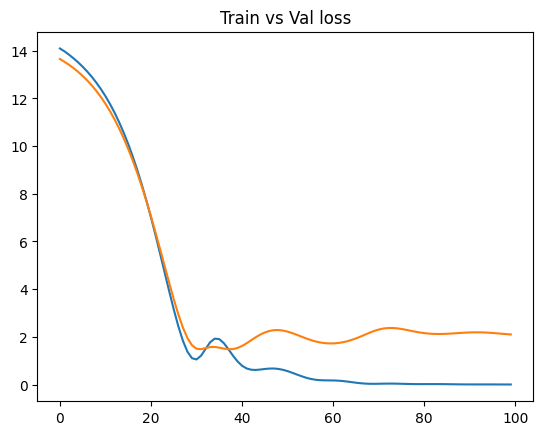

In [50]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss)
plt.plot(val_loss)

plt.title("Train vs Val loss");

In [51]:
# Evaluate Model
pred_ans = model.predict(test_model_input, batch_size=256)
print("test MSE", round(mean_squared_error(
    test[target].values, pred_ans), 4))

test MSE 2.0689
